# 生存時間分析
## 薬物利用1回目から2回目までの経過時間に関する時間分析

# 環境設定
本pjtでは、pipenvでの環境構築を行います。
```bash
pipenv shell
pip install -r requirements.txt
```

# 利用するデータについて
本pjtでは、以下のデータを用います。
- 麻薬中毒者再使用に関するデータセット

In [2]:
from SurvSet.data import SurvLoader
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from ydata_profiling import ProfileReport

In [3]:
# データセットの種類を取得
loader = SurvLoader()

#^ データセットの名前を取得してファイルに保存
list = loader.df_ds.ds
input = ""
for ds in list:
    input += ds+"\n"
with open("output/df_ds_name.txt", "w") as f:
    f.write(input)

#^ 麻薬中毒者の再入院に関するデータセットを読み込むみ、一応csvファイルとして保存する
df, ref = loader.load_dataset(ds_name="uis").values()
with open("output/uis_data.csv", "w") as f:
    f.write(df.to_csv(index=True))
with open("output/uis_ref.txt", "w") as f:
    f.write(ref)



# 探索的データ分析

## データフレームの形式や基本統計量の把握

## Ref
```txt
Description of the variables in the UIS Study described in Table 1.3
 of Hosmer, D.W. and Lemeshow, S. and May, S. (2008) Applied Survival
 Analysis: Regression Modeling of Time to Event Data: Second Edition,
John Wiley and Sons Inc., New York, NY


Data are in the file uis.dat

n = 628


Variable      Description                       Codes/Values                日本語での解説
id            Identification Code               1 - 628                     通し番号
age           Age at Enrollment                 Years                       年齢
beck          Beck Depression Score             0.000 - 54.000              ベック抑うつスコア
                at Admission
hercoc        Heroin/Cocaine Use During         1 = Heroin & Cocaine        ヘロイン, コカイン使用状況
                3 Months Prior to Admission     2 = Heroin Only
                                                3 = Cocaine Only
                                                4 = Neither Heroin
                                                    nor Cocaine
ivhx          IV Drug Use History at            1 = Never                   静脈注射薬利用歴
                Admission                       2 = Previous
                                                3 = Recent
ndrugtx       Number of Prior Drug              0 - 40                      過去の薬物治療回数
                Treatments
race          Subject's Race                    0 = White                   人種
                                                1 = Other
treat         Treatment Randomization           0 = Short                   治療ランダム割り付け
                Assignment                      1 = Long
site          Treatment Site                    0 = A                       治療施設
                                                1 = B
los           Length of Treatment               Days                        治療期間
                (Measured from Admission)
time          Time to Return to Drug Use        Days                        薬物再使用までの期間
                (Measured from Admission)
censor(event) Returned to Drug Use              1 = Returned to Drug Use    薬物再使用の有無
                                                0 = Otherwise
```

In [4]:
df.head()

pid  event  time fac_heroic fac_ivhx fac_race fac_treat fac_site  num_age  \
0    0      1   188          4        3        0         1        0     39.0   
1    1      1    26          4        2        0         1        0     33.0   
2    2      1   207          2        3        0         1        0     33.0   
3    3      1   144          4        3        0         0        0     32.0   
4    4      0   551          2        1        1         1        0     24.0   

   num_beck  num_ndrugtx  
0       9.0          1.0  
1      34.0          8.0  
2      10.0          3.0  
3      20.0          1.0  
4       5.0          5.0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pid          628 non-null    int64   
 1   event        628 non-null    int64   
 2   time         628 non-null    int64   
 3   fac_heroic   628 non-null    category
 4   fac_ivhx     628 non-null    category
 5   fac_race     628 non-null    category
 6   fac_treat    628 non-null    category
 7   fac_site     628 non-null    category
 8   num_age      623 non-null    float64 
 9   num_beck     595 non-null    float64 
 10  num_ndrugtx  611 non-null    float64 
dtypes: category(5), float64(3), int64(3)
memory usage: 32.8 KB


In [28]:
col_list = df.columns.tolist()

In [29]:
df.isnull().sum()

pid             0
event           0
time            0
fac_heroic      0
fac_ivhx        0
fac_race        0
fac_treat       0
fac_site        0
num_age         5
num_beck       33
num_ndrugtx    17
dtype: int64

<Axes: >

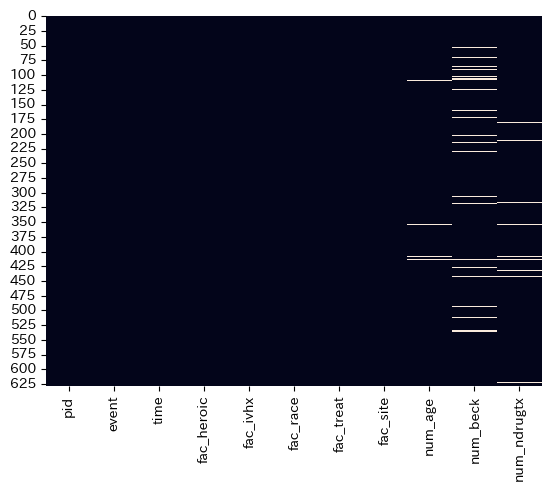

In [30]:
sns.heatmap(df.isnull(), cbar=False)

In [8]:
df.describe()

pid       event         time     num_age    num_beck  \
count  628.000000  628.000000   628.000000  623.000000  595.000000   
mean   313.500000    0.808917   234.703822   32.369181   17.404855   
std    181.432265    0.393468   201.701126    6.119534    9.391132   
min      0.000000    0.000000     2.000000   20.000000    0.000000   
25%    156.750000    1.000000    79.000000   27.000000   10.000000   
50%    313.500000    1.000000   166.000000   32.000000   17.000000   
75%    470.250000    1.000000   365.250000   37.000000   23.000000   
max    627.000000    1.000000  1172.000000   56.000000   54.000000   

       num_ndrugtx  
count   611.000000  
mean      4.574468  
std       5.494462  
min       0.000000  
25%       1.000000  
50%       3.000000  
75%       6.000000  
max      40.000000

# 割合の把握

- eventについて   
    0が未再使用, 1が再使用になる。
    - 未再使用等:薬物1回目の使用後に、2回目の利用が観察期間内に観察できていない個体 
    - 再使用: 薬物1回目の使用後に、2回目の利用を観察期間内に観察できた個体
- グラフからわかること
    - 再使用等が80.9%であり、ほとんどの薬物使用者が複数回の利用を行っていることがわかる。
    - 治療の有無により変化しているかは、このグラフからは検討できない

event
1    508
0    120
Name: count, dtype: int64


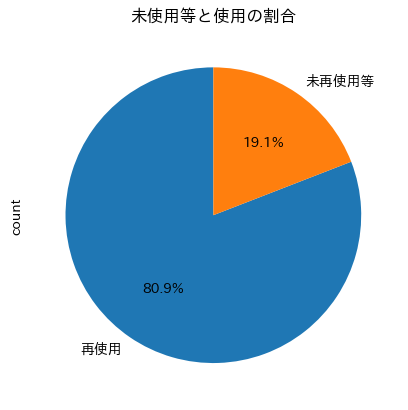

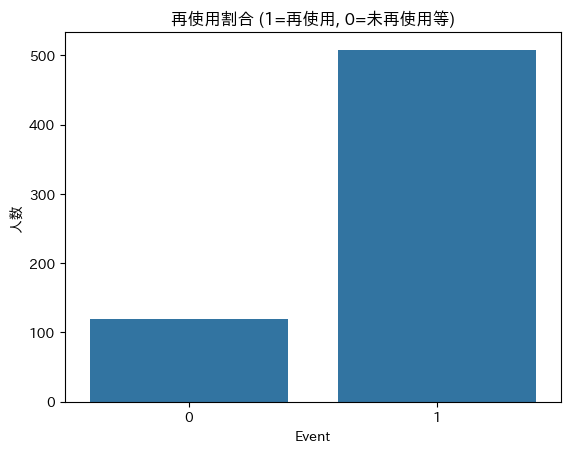

In [27]:
print(df['event'].value_counts())

# グラフ化
df['event'].value_counts().plot.pie(autopct='%1.1f%%', labels=['再使用', '未再使用等'], startangle=90)
plt.title('未使用等と使用の割合')
plt.show()

sns.countplot(x='event', data=df)
plt.title('再使用割合 (1=再使用, 0=未再使用等)')
plt.xlabel('Event')
plt.ylabel('人数')
plt.show()

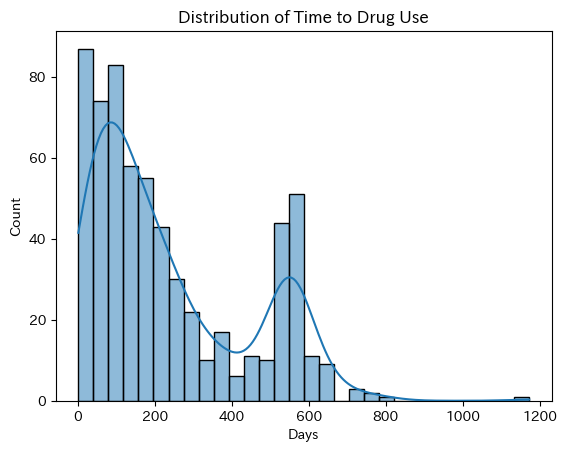

In [10]:
plt.figure()
sns.histplot(df['time'], bins=30, kde=True)
plt.title('Distribution of Time to Drug Use')
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()

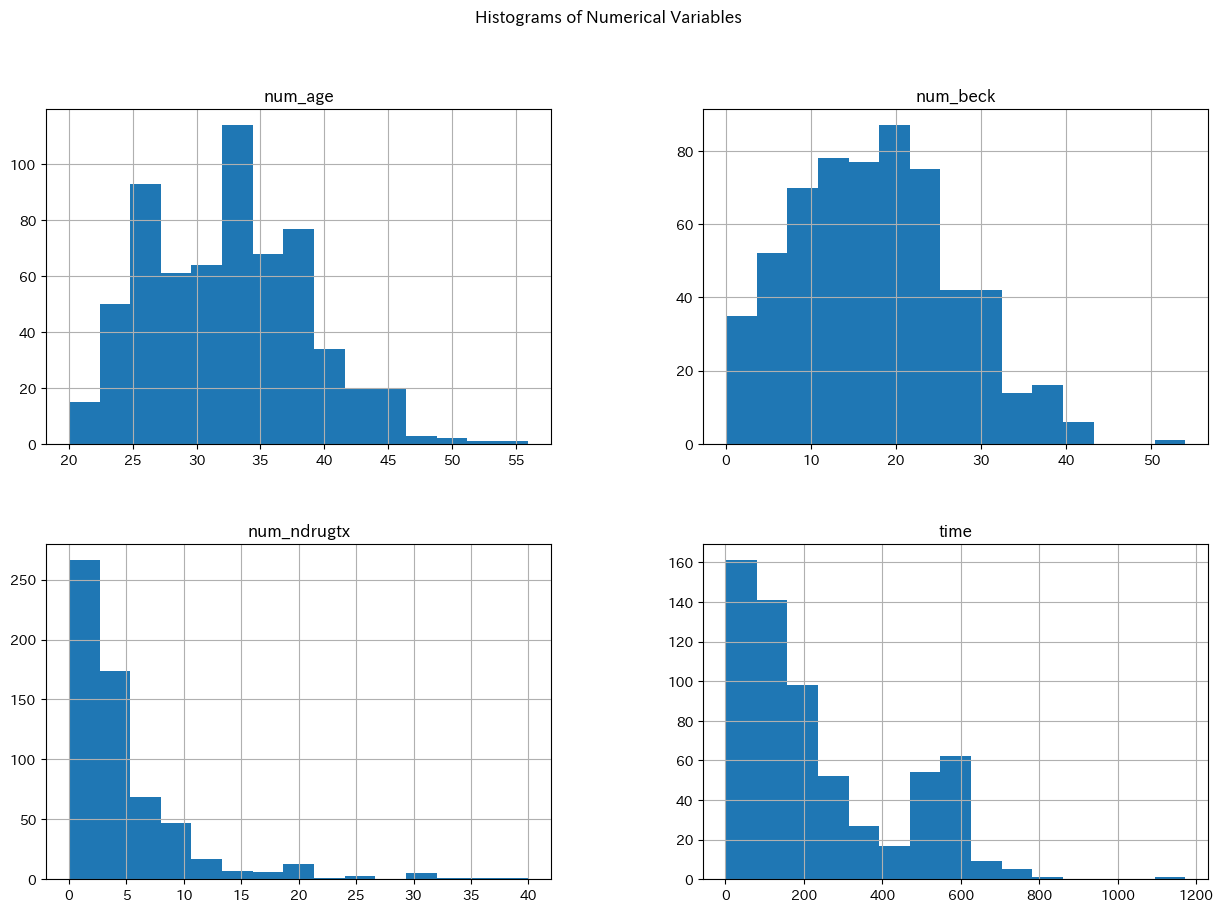

In [11]:
numerical_cols = ['num_age', 'num_beck', 'num_ndrugtx', 'time']
df[numerical_cols].hist(bins=15, figsize=(15,10))
plt.suptitle('Histograms of Numerical Variables')
plt.show()

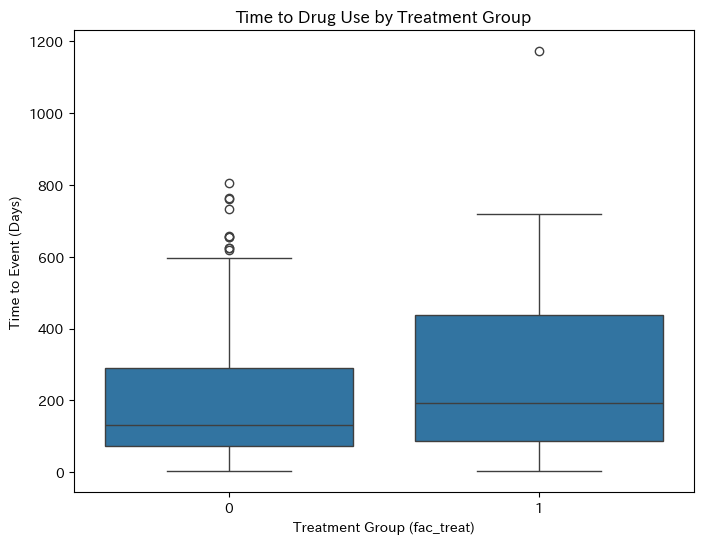

In [12]:
# fac_treat（0=Short, 1=Long）ごとの生存時間を可視化
plt.figure(figsize=(8,6))
sns.boxplot(x='fac_treat', y='time', data=df)
plt.title('Time to Drug Use by Treatment Group')
plt.xlabel('Treatment Group (fac_treat)')
plt.ylabel('Time to Event (Days)')
plt.show()

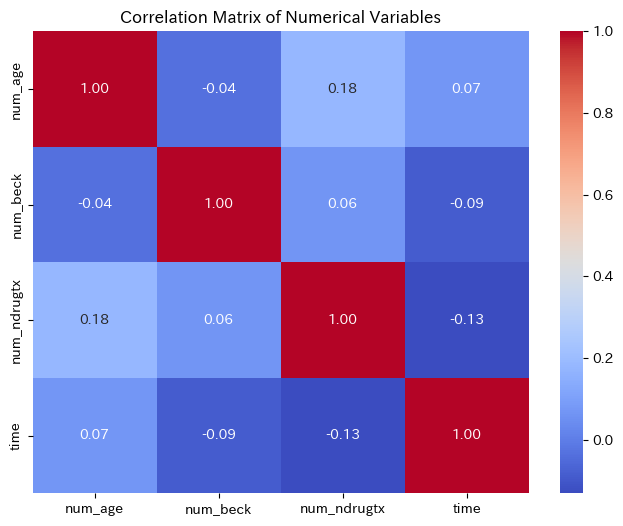

In [13]:
# 数値変数だけを抽出（欠損はそのままでもOK）
corr_df = df[['num_age', 'num_beck', 'num_ndrugtx', 'time']].copy()

# 欠損を一時的に埋める（平均など）
corr_df = corr_df.fillna(corr_df.mean())

# 相関マップ
plt.figure(figsize=(8,6))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

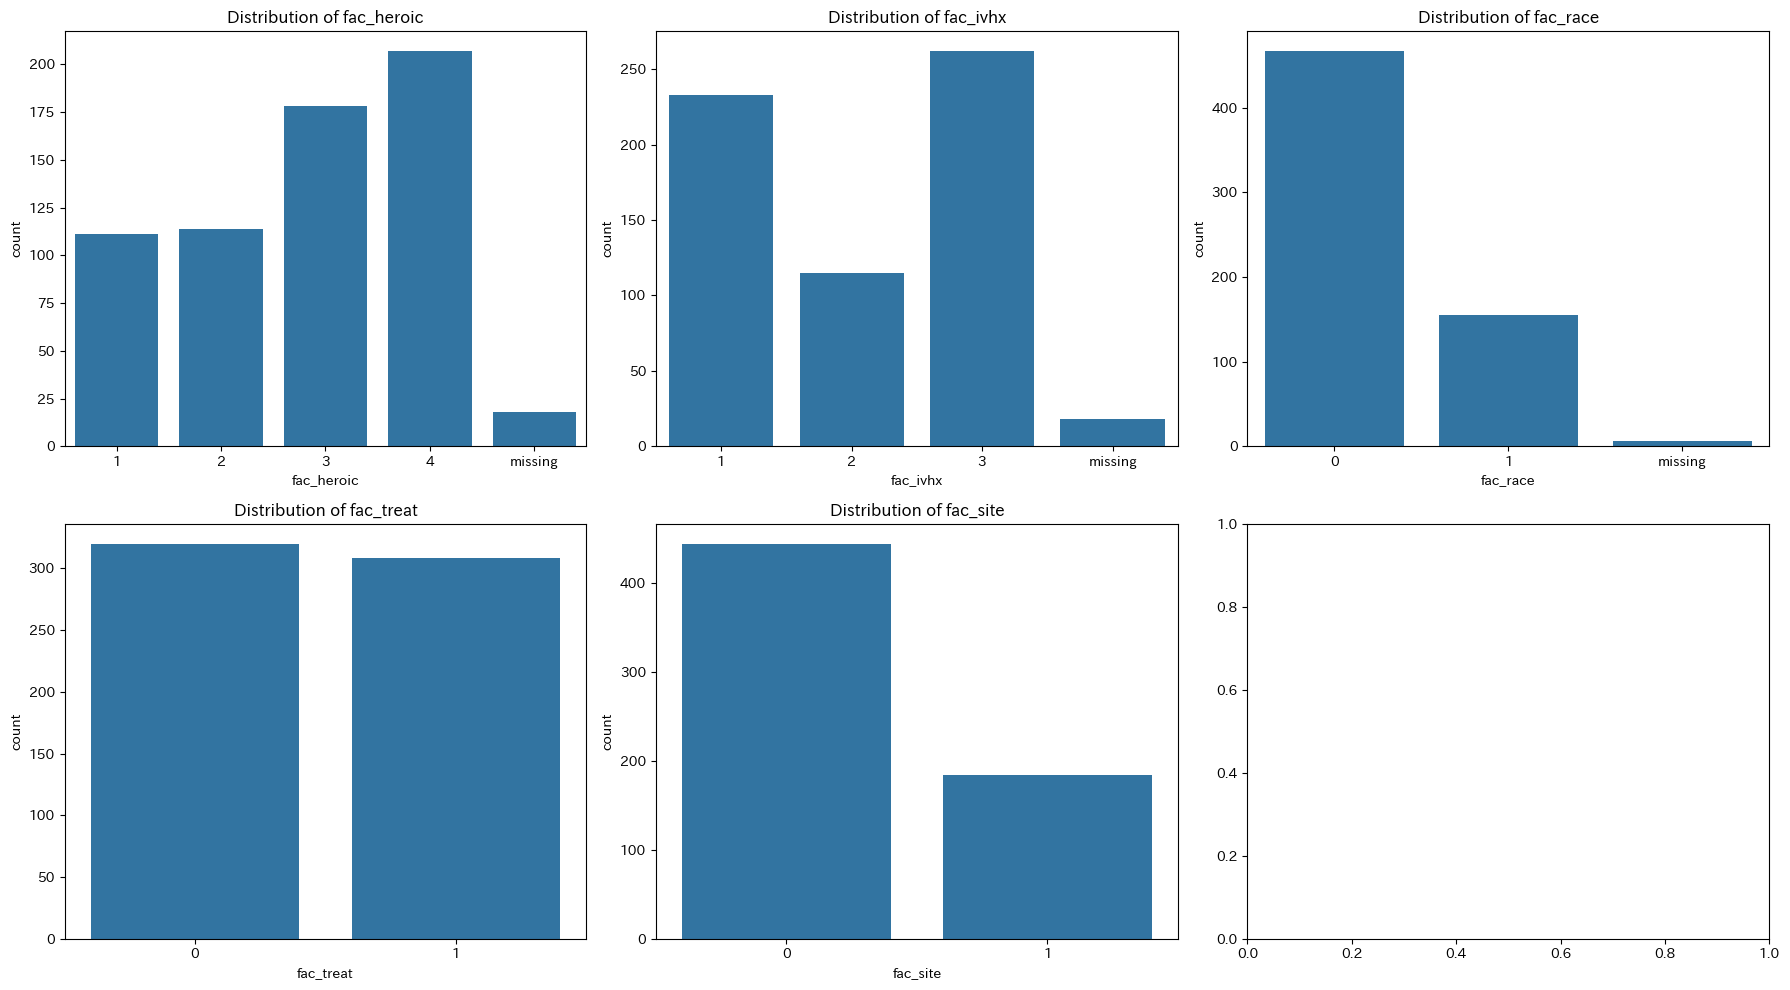

In [14]:
categorical_cols = ['fac_heroic', 'fac_ivhx', 'fac_race', 'fac_treat', 'fac_site']

fig, axes = plt.subplots(2, 3, figsize=(18,10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

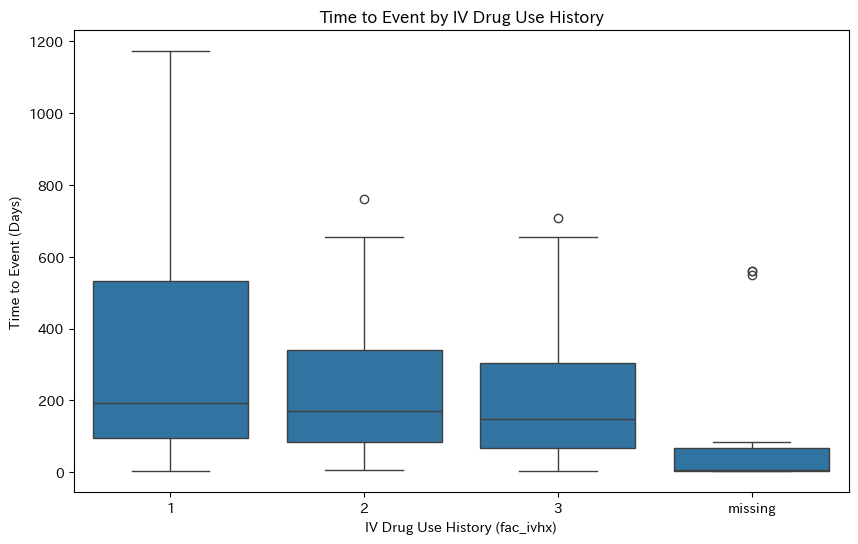

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(x='fac_ivhx', y='time', data=df)
plt.title('Time to Event by IV Drug Use History')
plt.xlabel('IV Drug Use History (fac_ivhx)')
plt.ylabel('Time to Event (Days)')
plt.show()

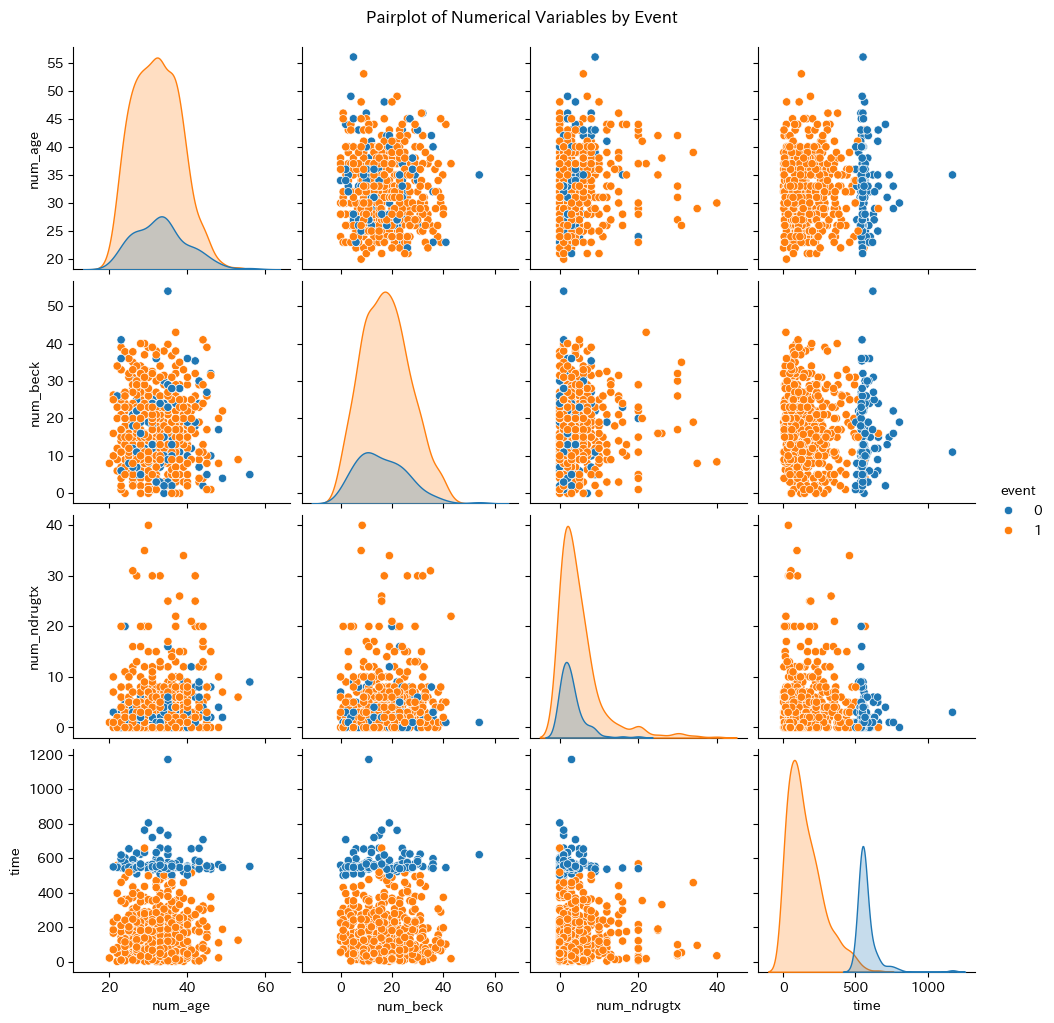

In [16]:
sns.pairplot(df, vars=['num_age', 'num_beck', 'num_ndrugtx', 'time'], hue='event')
plt.suptitle('Pairplot of Numerical Variables by Event', y=1.02)
plt.show()

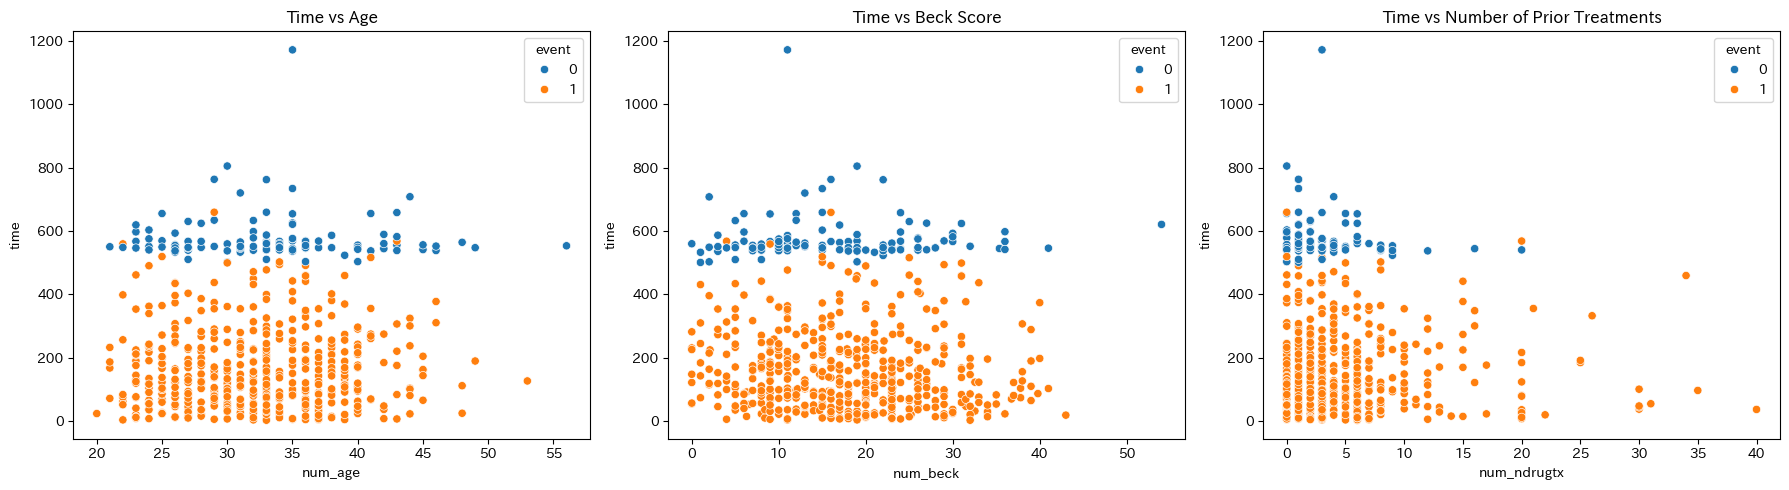

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.scatterplot(x='num_age', y='time', hue='event', data=df, ax=axes[0])
axes[0].set_title('Time vs Age')

sns.scatterplot(x='num_beck', y='time', hue='event', data=df, ax=axes[1])
axes[1].set_title('Time vs Beck Score')

sns.scatterplot(x='num_ndrugtx', y='time', hue='event', data=df, ax=axes[2])
axes[2].set_title('Time vs Number of Prior Treatments')

plt.tight_layout()
plt.show()

In [18]:
# プロファイルレポートの作成
profile = ProfileReport(df, title="UIS Dataset EDA Report", explorative=True)

# Jupyter Notebookなら
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 115922.97it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
profile.to_file("output/uis_eda_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

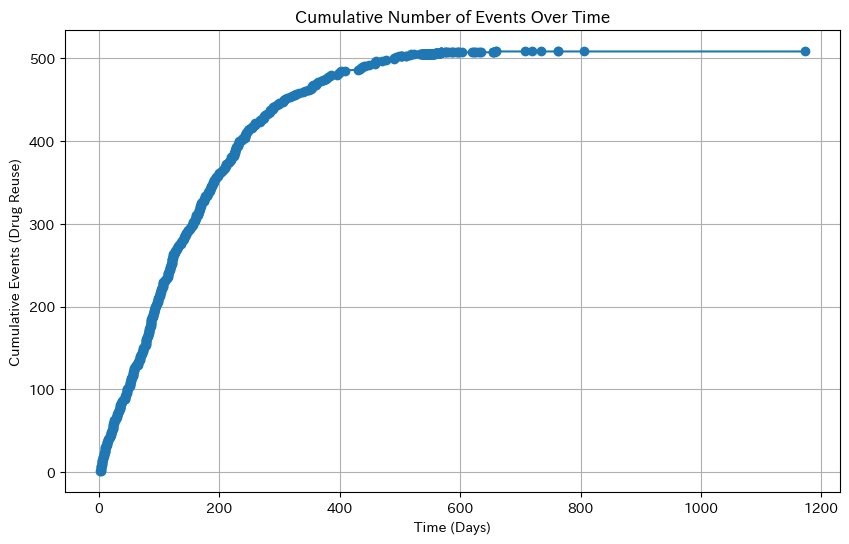

In [20]:
# 時間順に並び替え
df_sorted = df.sort_values('time')

# イベント発生（event=1）の累積和
df_sorted['cumulative_events'] = (df_sorted['event'] == 1).cumsum()

# 折れ線グラフ
plt.figure(figsize=(10,6))
plt.plot(df_sorted['time'], df_sorted['cumulative_events'], marker='o', linestyle='-')
plt.title('Cumulative Number of Events Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Cumulative Events (Drug Reuse)')
plt.grid(True)
plt.show()

/var/folders/wb/sqvg1jfx4qvbgf2ndb8gt5300000gn/T/ipykernel_73540/475762761.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df_sorted.groupby('fac_treat'):


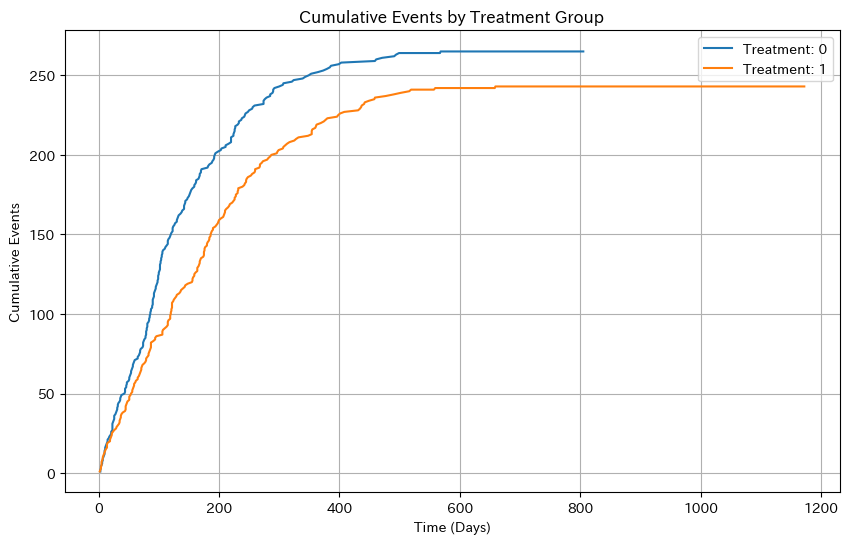

In [21]:
plt.figure(figsize=(10,6))

for name, group in df_sorted.groupby('fac_treat'):
    group = group.sort_values('time')
    group['cumulative_events'] = (group['event'] == 1).cumsum()
    label = f'Treatment: {name}'
    plt.plot(group['time'], group['cumulative_events'], label=label)

plt.title('Cumulative Events by Treatment Group')
plt.xlabel('Time (Days)')
plt.ylabel('Cumulative Events')
plt.legend()
plt.grid(True)
plt.show()

# カプランマイヤー曲線を用いた分析
- 横軸が時間の流れ
- 縦軸が、生存割合

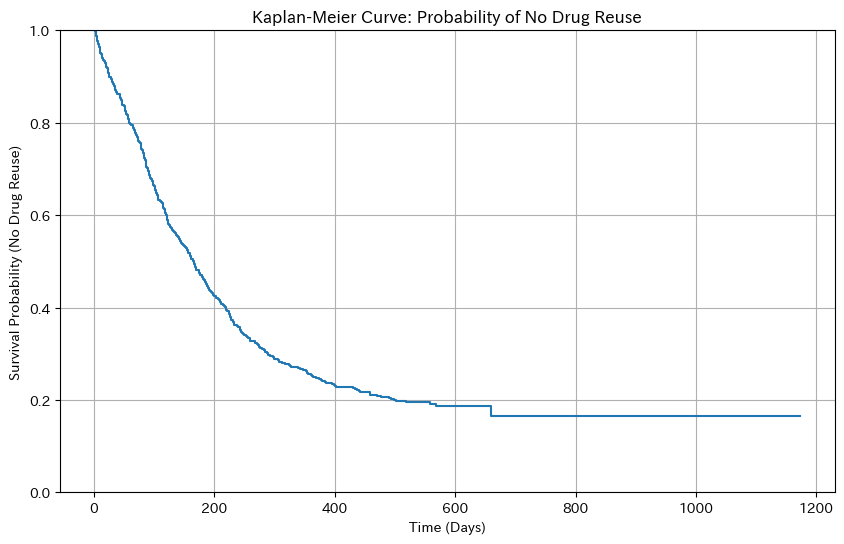

In [22]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

# イベント情報と生存時間
time = df['time']
event = df['event'] == 1  # True = 再使用

# カプランマイヤー推定
times, survival_prob = kaplan_meier_estimator(event, time)

# プロット
plt.figure(figsize=(10,6))
plt.step(times, survival_prob, where="post")
plt.title("Kaplan-Meier Curve: Probability of No Drug Reuse")
plt.xlabel("Time (Days)")
plt.ylabel("Survival Probability (No Drug Reuse)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

/var/folders/wb/sqvg1jfx4qvbgf2ndb8gt5300000gn/T/ipykernel_73540/584266863.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby('fac_treat'):


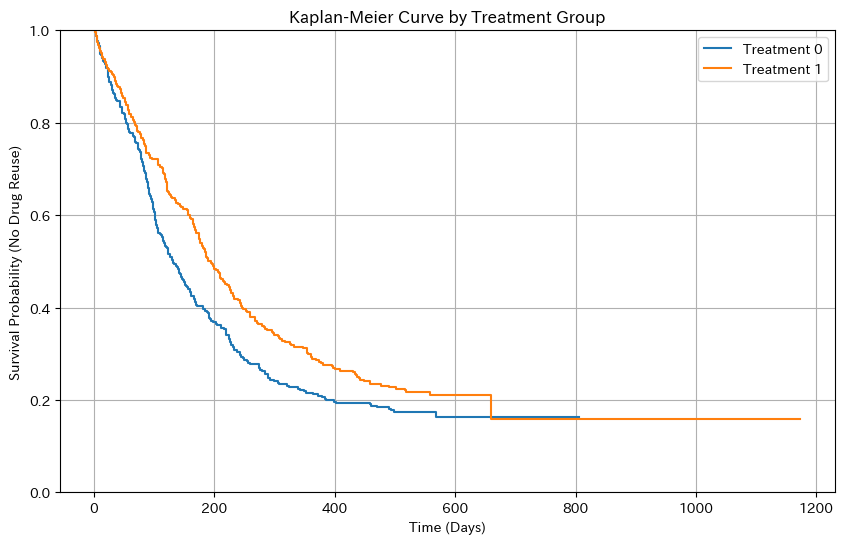

In [23]:
plt.figure(figsize=(10,6))

for name, group in df.groupby('fac_treat'):
    time_g = group['time']
    event_g = group['event'] == 1
    times, surv_prob = kaplan_meier_estimator(event_g, time_g)
    label = f'Treatment {name}'
    plt.step(times, surv_prob, where="post", label=label)

plt.title('Kaplan-Meier Curve by Treatment Group')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability (No Drug Reuse)')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# ログランク検定
- 有意の差があるかどうかの検定 -> どのくらいの差があるかは判定できない

# Cox回帰(比例ハザードモデル)による、影響度評価
### 特徴
- 何倍長生きしやすいか
- 発生率の割合(比)を求められる

### 条件
- 比例ハザードモデルを利用している(時間によらず一定である)

# 比例ハザード性がない場合の推定

# まとめ